# Chapter 5 - The ARMA Model

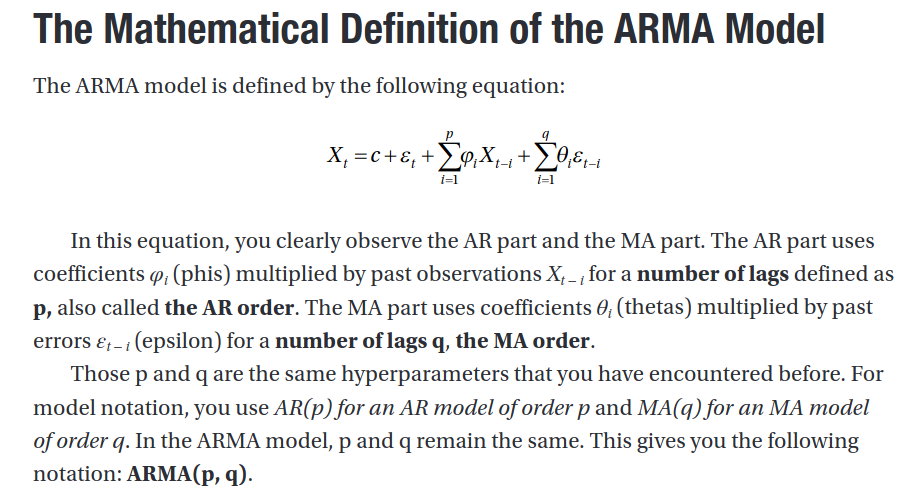

## Listing 5-1. Getting the Sunspot data into Python

The sunspot dataset is well known for having a specific pattern of seasonal effects over 11-year periods. The dataset is not very detailed: it just contains the data counts per
month.

In [ ]:
import pandas as pd

url = 'https://raw.githubusercontent.com/Apress/advanced-forecasting-python/main/Ch05_Sunspots_database.csv'
data = pd.read_csv(url)

#data = pd.read_csv('Ch05_Sunspots_database.csv', usecols = [1, 2])


## Listing 5-2. Aggregating the sunspot data to yearly data

In [ ]:
data['year'] = data.Date.apply(lambda x: x[:4])
data = data[['Monthly Mean Total Sunspot Number', 'year']].groupby('year').sum()
data.head()


,Monthly Mean Total Sunspot Number
year,
1749,1618.5
1750,1668.0
1751,953.3
1752,956.0
1753,613.5


Let’s also make a plot over time to see what type of variation you are working with.

## Listing 5-3. Plotting the yearly sunspot data

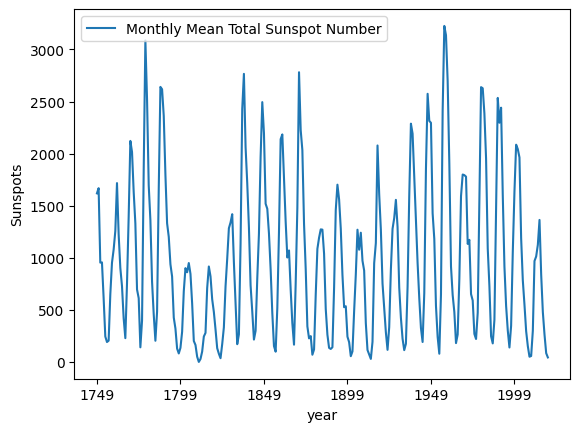

In [ ]:
import matplotlib.pyplot as plt
ax = data.plot()
ax.set_ylabel('Sunspots')
plt.show()


Looking at this plot, the pattern is already strikingly clear: high peaks on regular intervals. Let’s see how to use the ARMA model to capture this pattern and make predictions for the future. The first step, as always, is to verify whether the data is stationary or not.

Remember that stationarity means that there is no long-term trend in the data: the average is constant over time. When looking at the data, there is no obvious long-term trend, yet you can use the ADF test (Augmented Dickey Fuller test) to confirm this for you.

## Listing 5-4. Applying the ADF test to the sunspot yearly totals

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['Monthly Mean Total Sunspot Number'])
print(result)

pvalue = result[1]

if pvalue < 0.05:
    print('stationary')
else:
    print('not stationary')


(-2.793301611683588, 0.059236973871617395, 8, 262, {'1%': -3.455558114028747, '5%': -2.872635586277424, '10%': -2.572682677000175}, 3625.6631160815896)
not stationary


The result that you obtain when applying this test is unexpected: the ADF test tells you that the data is not stationary. In this case, the intuitive decision would be to assume stationarity, while the ADF tells you not to. A choice has to be made.

For now, let’s keep it the easiest possible and stay with the original data.

Now the second thing to look at is the autocorrelation function (ACF) and the partial autocorrelation function (PACF). Remember that the ACF and PACF plots can help you to define whether you are working with AR or MA processes. You can obtain the ACF and PACF using Listing 5-5

## Listing 5-7. Creating the ACF and PACF plots

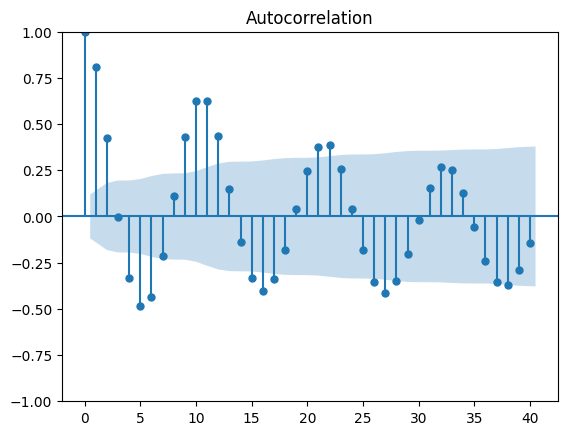

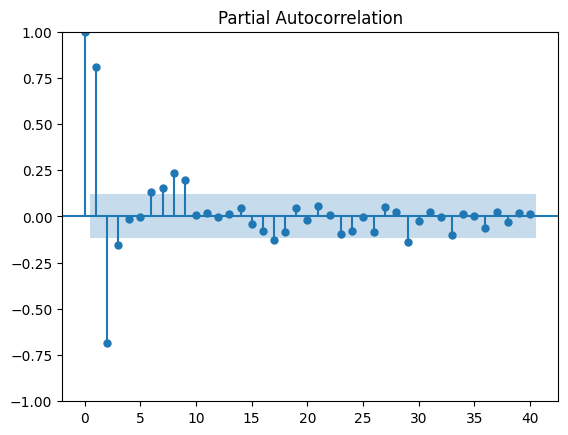

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plot_acf(data['Monthly Mean Total Sunspot Number'], lags=40)

plot_pacf(data['Monthly Mean Total Sunspot Number'], lags=40)

plt.show()


The ACF and PACF plots are great cases to study time series
patterns; it is rare to observe such strong patterns on real-life data.

Remember from the previous session which type of patterns you should be looking at:

• AR processes are recognized by
-------------------------------
  
  • Exponentially decaying partial autocorrelation
  
  • Partial autocorrelation decaying toward zero

  • Swings between negative and positive partial autocorrelation

  ------------------------------------

• MA processes are identified by
-----------------------------
-------------------------

  
  • Sudden spikes in the ACF and PACF

This means that in the sunspot case, you have a strong indicator for observing an AR pattern: there is exponential decay in the PACF, together with switching from negative to
positive. There is no real evidence for an MA process when looking at those plots.

The ARMA(p,q) model being simply the combination of the AR and MA models, it is important to realize that there is an optimization going on that finds the coefficients of the model that minimize the Mean Squared Error of the model.

## Listing 5-8. Fitting the ARMA(1,1) model

0.7609036836987519


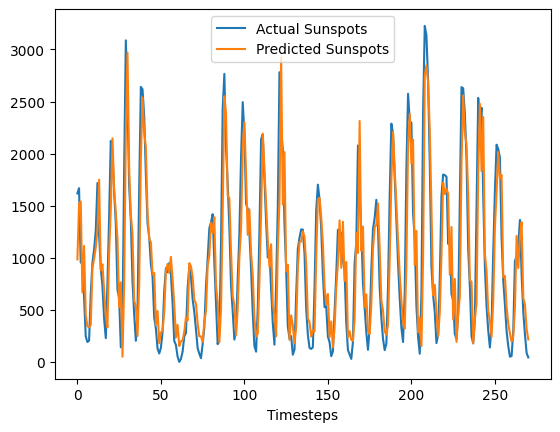

In [ ]:
from sklearn.metrics import r2_score
from statsmodels.tsa.arima.model import ARIMA

# Forecast the first ARMA(1,1) model
mod = ARIMA(list(data['Monthly Mean Total Sunspot Number']), order=(1,0,1))
res = mod.fit()
pred = res.predict()
print(r2_score(data, pred))

plt.plot(list(data['Monthly Mean Total Sunspot Number']))
plt.plot(pred)
plt.legend(['Actual Sunspots', 'Predicted Sunspots'])
plt.xlabel('Timesteps')
plt.show()


Remember that there is an important difference between coefficients and hyperparameters.

Coefficients are estimated by the model, whereas hyperparameters must be chosen by the modeler.

In the ARMA(p,q) model, p and q are the hyperparameters that you must decide on using plots, performance metrics, and more.

## Listing 5-9. Plotting a histrogram of the residuals

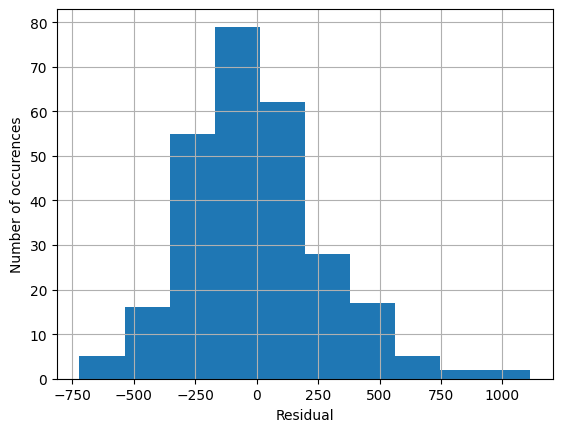

In [ ]:
ax = pd.Series(res.resid).hist()
ax.set_ylabel('Number of occurences')
ax.set_xlabel('Residual')
plt.show()


You can observe visually that the histogram of the residuals is not following the bell-shaped curve that is the normal distribution. This means that there are probably some lags to be added, which is logical: you already know that the sunspot data has an 11-year seasonality, and for now there is only one lagged period (1 year back) included in the model.

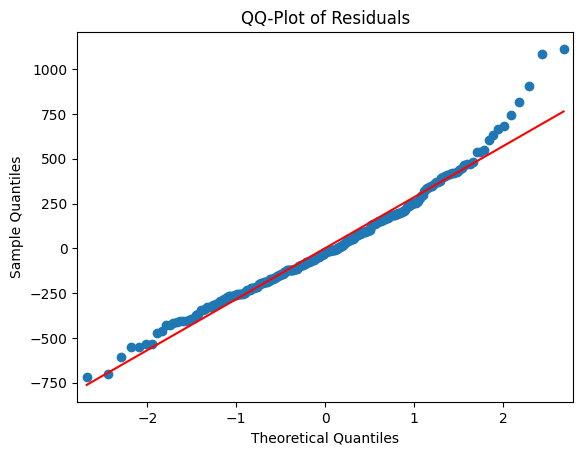

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Assuming you have the residuals stored in a variable called 'residuals'
# Replace this with your actual residuals data
residuals = res.resid

# Create a QQ-Plot
sm.qqplot(residuals, line='s')
plt.title('QQ-Plot of Residuals')
plt.show()


## Listing 5-10. Obtaining the summary table of your model’s fit

In [ ]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  271
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1987.170
Date:                Wed, 08 Nov 2023   AIC                           3982.341
Time:                        15:14:14   BIC                           3996.749
Sample:                             0   HQIC                          3988.126
                                - 271                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        984.7442    153.327      6.423      0.000     684.229    1285.259
ar.L1          0.7193      0.051     14.024      0.000       0.619       0.820
ma.L1          0.5254      0.053      9.922      0.000       0.422       0.629
sigma2      1.361e+05   1.09e+04     12.479      0.000    1.15e+05    1.58e+05
===================================================================================
Ljung-Box (L1) (Q):                   8.44   Jarque-Bera (JB):                41.94
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.43   Skew:                             0.81
Prob(H) (two-sided):                  0.09   Kurtosis:                         4.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Important pieces of information that you can get from this table are the estimates of the coefficients and the corresponding p-values.

Remember that you are working with an ARMA(1,1) model and that you therefore will have one coefficient for the AR model
(for the data point one time step back) and one coefficient for the MA model (for the error of one time step back).

When you fit the model in the data, your model is estimating the best possible values for those coefficients.

You can see the estimates of the coefficients in the table on the line that says ar.L1 (AR coefficient for the first lag is 0.7193) and on the line that says ma.L1
(MA coefficient for the first lag is 0.5254).

You can interpret those by looking back to the formula.

Basically, those estimates state that you can predict a future data point, by filling in the ARMA formula using
the const as c, the ar.L1 as coefficient φi (phi), and the ma.L1 as coefficient θi (tetha)


Filling in those coefficients would allow you to compute the next value. This is great information for understanding what information is used by your model to predict the future.

Now that you know the estimated values of your coefficients, you can also look at the hypothesis tests for those coefficients. For each coefficient, the summary table shows
a hypothesis test that tells you whether the coefficient is significantly different from zero. If a coefficient were to be zero, this would mean that it is not useful to include the
parameter. Yet, if a hypothesis test proves that a coefficient is significantly different from zero, this means that it is useful to add the coefficient in your model. This helps you in deciding which order to use for your ARMA forecast.

The p-values of the hypothesis tests can be found on the line of the coefficient, under the column P>|z|.

This column gives you the p-value of the hypothesis test.

The p-value must be smaller than 0.05 to prove that the coefficient is significantly different from
zero.

In this case, the interpretation is as follows:

• The p-value for the ar.L1 coefficient is 0.000, so significant.

• The p-value for the ma.L1 coefficient is also 0.000, so significant.

• Both are smaller than 0.05, and therefore you can conclude that both coefficients should be retained in the model.

As you can imagine, this is very useful information when creating a model. You can go back and forward between increasing and decreasing the order of AR and MA independently and try to find at which point the coefficients start to become insignificant (p-values higher than 0.05) in which case you take the order of the highest lag that was still significant as the best model. Of course, keep in mind that significance is one indicator between multiple indicators.

# Automated Hyperparameter Tuning
Although this theoretical approach can be very interesting, you should combine it with tests of predictive performance.

The goal of a grid search for hyperparameter optimization is to make the task of choosing hyperparameters.

You have seen multiple statistical tools that can help you to
make the choice:

• Autocorrelation function (ACF)

• Partial autocorrelation function (PACF)

• Model residuals

• Summary table

With multiple indicators, it is difficult to decide on the best parameters. A grid search is a method that will test every combination of hyperparameters and evaluate the predictive error of this combination of hyperparameters. This will give you an objective estimate of the hyperparameters that will obtain the best performance. A basic approach for a grid search is to make a train-test split and to fit a model
with each combination of hyperparameters on the train set and evaluate the model on the test set.

In practice, a grid search is often combined with cross-validation. Cross-validation is an augmentation of the train-test split approach in which the train-test split is repeated multiple times. This yields a more reliable error
estimate.

To apply a grid search with cross-validation, you need to implement a loop through each combination of hyperparameters (in this case, p and q).

For each combination, the code will split the data in multiple cross-validation splits: multiple combinations
of train-test splits.

Those splits are also called folds. For each of those folds, you train the model on the train set and test the model on the test set.

This yields an error for each fold, of which you take the average to obtain an error for each hyperparameter
combination.

The hyperparameter combination with the best error will be the model that you retain for your forecast.

## Listing 5-11. Grid search with cross-validation for optimal p and q

In [ ]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
data_array = data.values

avg_errors = []

for p in range(13):
    for q in range(13):

        errors = []

        tscv = TimeSeriesSplit(test_size=10)

        for train_index, test_index in tscv.split(data_array):

            X_train, X_test = data_array[train_index], data_array[test_index]
            X_test_orig = X_test

            fcst = []
            for step in range(10):

                try:
                    mod = ARIMA(X_train, order=(p,0,q))
                    res = mod.fit()

                    fcst.append(res.forecast(steps=1))

                except:
                    print('errorred')
                    fcst.append(-9999999.)

                X_train = np.concatenate((X_train, X_test[0:1,:]))
                X_test = X_test[1:]

            errors.append(r2_score(X_test_orig, fcst))

        pq_result = [p, q, np.mean(errors)]

        print(pq_result)
        avg_errors.append(pq_result)

avg_errors = pd.DataFrame(avg_errors)
avg_errors.columns = ['p', 'q', 'error']
result = avg_errors.pivot(index='p', columns='q')


[0, 0, -0.16591515438439544]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.p

[0, 1, 0.5282302939817131]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.p

[0, 2, 0.6666513009254765]
[0, 3, 0.70090999936557]
[0, 4, 0.7389201848749503]
[0, 5, 0.7470420133179224]
[0, 6, 0.747013962690062]


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0, 7, 0.7406546561380541]


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0, 8, 0.759044295594816]


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

[0, 9, 0.7328338171059345]


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible s

[0, 10, 0.7262710273890919]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Like

[0, 11, 0.7797341409352129]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Like

[0, 12, 0.7568863380850488]
[1, 0, 0.6082112377424933]
[1, 1, 0.7040643922958199]
[1, 2, 0.7149075987261037]
[1, 3, 0.7332666343872065]


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

[1, 4, 0.7280331010310671]


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

[1, 5, 0.7446490826158005]


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

[1, 6, 0.7569763541093744]


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

[1, 7, 0.7473423654284648]


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

[1, 8, 0.7490585919789298]


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

[1, 9, 0.7673791869487168]


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

[1, 10, 0.7753669617898501]


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

errorred


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


errorred


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


errorred
errorred


## Listing 5-12. Showing the test prediction of the final model

The combination that has yielded the best R2 score is the combination of p = 10 and q = 9, which yields an estimated R2 score on the test set of 0.84.

As a final step, you can refit the model on a train-test split to plot this on a train-test set to see what this error looks like.

In [ ]:
data_array = data.values
X_train, X_test = data_array[:-10], data_array[-10:]
X_test_orig = X_test

fcst = []
for step in range(10):
    mod = ARIMA(X_train, order=(10,0,9))
    res = mod.fit()
    fcst.append(res.forecast(steps=1))
    X_train = np.concatenate((X_train, X_test[0:1,:]))
    X_test = X_test[1:]

plt.plot(X_test_orig)
plt.plot(fcst)
plt.legend(['Actual Sunspots', 'Predicted Sunspots'])
plt.xlabel('Time steps of test data')
plt.show()
